# Study Subway Data

In [1]:
# Load necessary python libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# For time checks
import time

# Scikit learn models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import SGDRegressor

# Cross-validation helpers
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# Polynomial generator
from sklearn.preprocessing import PolynomialFeatures

# Set random seed, so our results are similar
# Where does 42 come from?
np.random.seed(42)

# Reading data

In [2]:
datafile = 'subway_neighbor_df.csv'
df = pd.read_csv(datafile).dropna()
df['Datetime'] = pd.to_datetime(df['Datetime'])

In [3]:
print(df)

                   Datetime                               Stop Name  \
0       2017-02-04 08:00:00                                    1 Av   
1       2017-02-04 12:00:00                                    1 Av   
2       2017-02-04 16:00:00                                    1 Av   
3       2017-02-04 20:00:00                                    1 Av   
4       2017-02-05 00:00:00                                    1 Av   
...                     ...                                     ...   
4589375 2021-08-13 00:00:00  Sutphin Blvd - Archer Av - JFK Airport   
4589376 2021-08-13 04:00:00  Sutphin Blvd - Archer Av - JFK Airport   
4589377 2021-08-13 08:00:00  Sutphin Blvd - Archer Av - JFK Airport   
4589378 2021-08-13 12:00:00  Sutphin Blvd - Archer Av - JFK Airport   
4589379 2021-08-13 16:00:00  Sutphin Blvd - Archer Av - JFK Airport   

                    Line               Neighborhood  Entries      Time  \
0               Canarsie  Lower East Side/Chinatown   1205.0  08:00:00   

The final model we will present is the times series model, which is quite different from the rest. Each station's subway flow forms individual time series of their own in the entire dataset. So we found that instead of performing time series analysis on the entire dataset collectively, it's more practical to examine the invidual stations’ time series separately. Two specific stations, 1st Avenue Station (Canarsie Line) and Broad Street Station (Jamaica Line), were selected for analysis. Besides, the data was transformed from hourly to daily because it would be more useful.

Attempts to create a time series of Average Flow revealed consistent values daily from 2017 to 2021, making predictions meaningless. Therefore, we chose Normalized flow as a more suitable dependent variable for the time series model. The code and diagrams below displays the differences between average flow and normalized flow for 1st Avene station clearly. 

-- Henry
We first attemped to perform time series data analysis on each station's Average_Flow but only found it to be meaningless as the Average_Flow only cycles through the same 6 values every day through out the whole period, for 6 specific hours (e.g, 0:00, 4:00, 8:00, 12:00, 16:00, 20:00).  Obviously this data has been processed based on some averaging method.  Instead, we found ridership data from another column, Normalize_Flow, make a lot of more sense.  For example, it clearly shows both the short-term (e.g., over different hours during a day and over different days over a week),  and lont-term varations (e.g., the drastic disruption caused by Covid-19 and and slow recovery after the peak of the pandemic).  Further investigations into the Normalized_Flow ridership data reveals two facts: (1) the ridership of the same station has significant differences over different period of time such as pre-Covid and post-Covid period; and (2) different stations also have quite different ridership data during the same period.  

As expected, each station's Normalized_Flow has shown two strong seasonalities: seasonality cross the 24-hour period and the seasonality cross the 7-day period.  In this analysis we decided to only study the daily ridership data instead of the original per reading in every 4 hours, because we believed predicting daily ridership is of more interest in pratical.  To do so, we summed the Normalized_Flow cross each day to obtain the daily data.  A simple analysis on the daily data shows strong seasonality cross 7 days, as expected.  Auto ARIMA model with seasonality is used to predict the daily ridership of the next 28 days after the model is trained with roughtly 365 days of data, which means roughly ~13-month of data (400 days of data) is used for the analysis. In addition, two different 13-month windows ( are chosen for each station, one before Covid and one after, to show the drastic change of the ridership caused by Covid.  The data from mulitple stations were analyzed and we will use two randomly selected stations (Stop 1 Ave at Canarise Line, and Stop Broad St. at Jamaica Line) to demonstrate our work.


### Look into the Average_Flow of Station 1 (1 Ave at Canarsie Line)

<Figure size 1000x600 with 0 Axes>

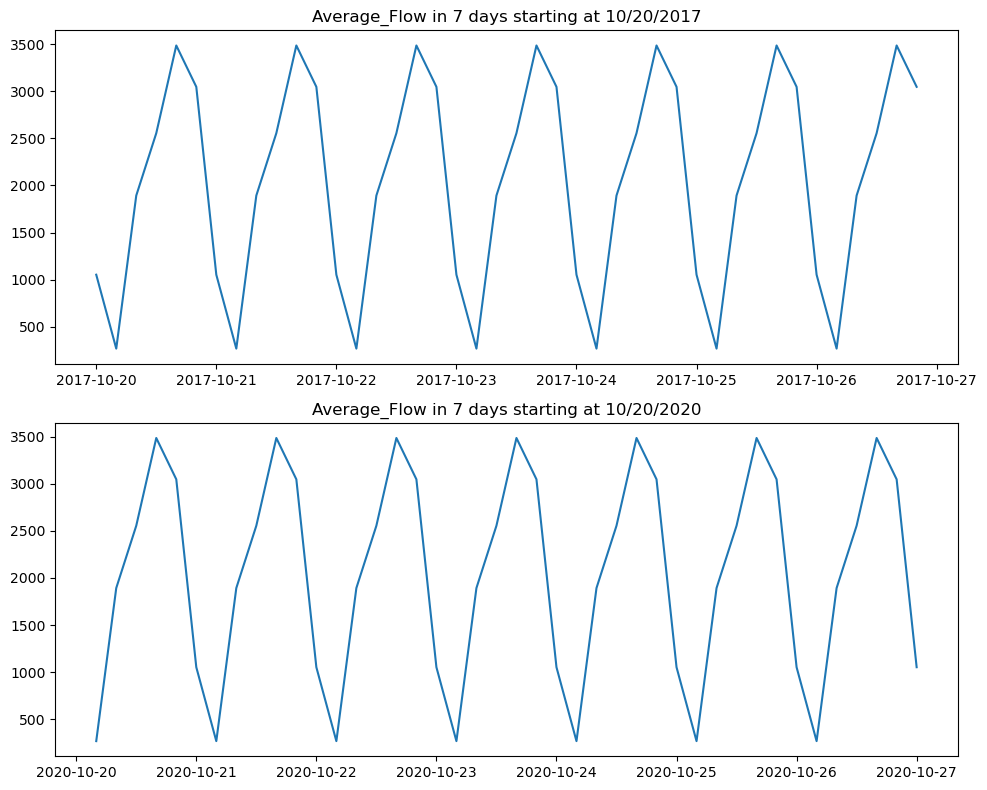

In [17]:
df1 = df[(df['Stop Name'] == '1 Av') & (df['Line'] == 'Canarsie')] #One line, one stop
#print(df1['Average_Flow'])

df1_time_flow = df1[['Datetime', 'Average_Flow']].copy() #We keep only the Datetime and Normalized Flow columns
df1_time_flow.set_index('Datetime', inplace=True) # Using date as the index


k = len(df1['Average_Flow']) + 1

#import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))

# Create a 1x2 grid of subplots to show the traffic pattern in 2017 and 2021
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

axes[0].plot(df1_time_flow.iloc[1542:1584], linestyle='-')
axes[1].plot(df1_time_flow.iloc[8000:8042], linestyle='-')

# Set titles for subplots
axes[0].set_title('Average_Flow in 7 days starting at 10/20/2017')
axes[1].set_title('Average_Flow in 7 days starting at 10/20/2020')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

### Average flow is identical every day, between 2017 and 2021, as proven in the samples below

###  Look into the Normalized_Flow of Station 1 (1 Ave at Canarsie Line)



<Figure size 1000x600 with 0 Axes>

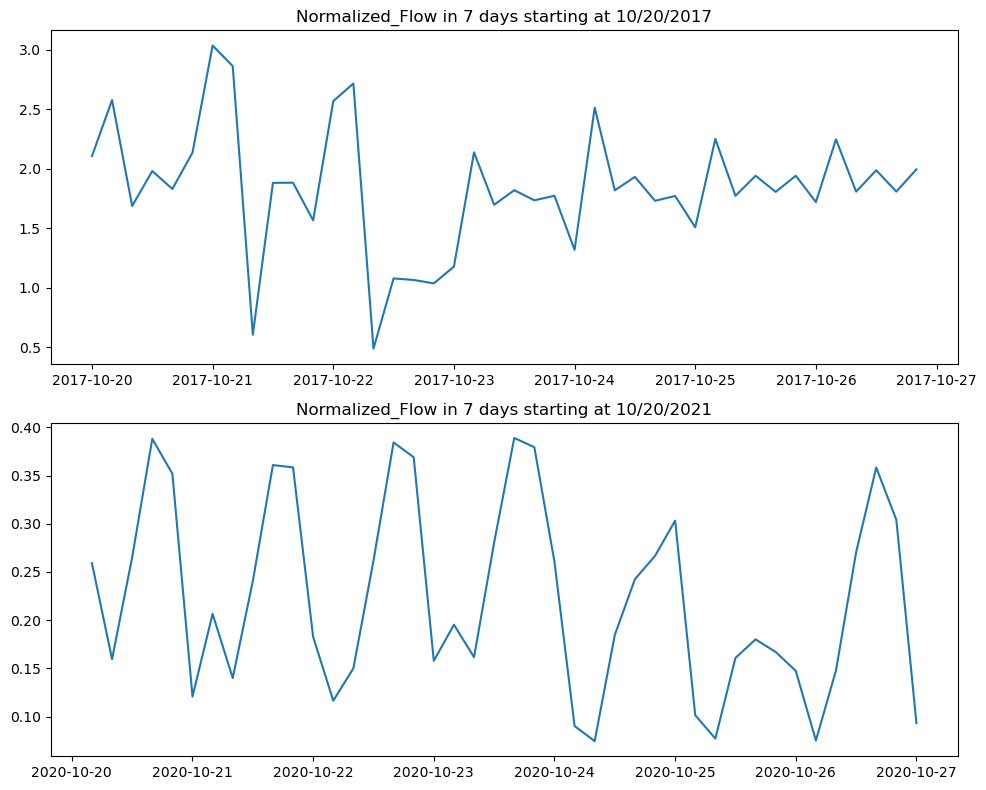

In [4]:
df1 = df[(df['Stop Name'] == '1 Av') & (df['Line'] == 'Canarsie')] #One line, one stop 

df1_time_flow = df1[['Datetime', 'Normalized_Flow']].copy() #Keeping only the Datetime and Normalized Flow columns 
df1_time_flow.set_index('Datetime', inplace=True) # using date as the index
#df1_time_flow.head()

k = len(df1_time_flow) + 1

import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))

# Create a 1x2 grid of subplots to show the traffic pattern in 2017 and 2021
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

axes[0].plot(df1_time_flow.iloc[1542:1584], linestyle='-')  # ridership in 2017
axes[1].plot(df1_time_flow.iloc[8000:8042], linestyle='-')  # ridership in 2021

# Set titles for subplots
axes[0].set_title('Normalized_Flow in 7 days starting at 10/20/2017') 
axes[1].set_title('Normalized_Flow in 7 days starting at 10/20/2021')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()



The above figures shows a strong seasonality throughout different hours within each day, which is easy to understand.  In addition, it can be noted that the ridership in 2020 is only about 1/10 of what was in 2017 during the same period, due to the Covid-19 pandenmic.  In the following we will only study the daily ridership data as it is of more interest.

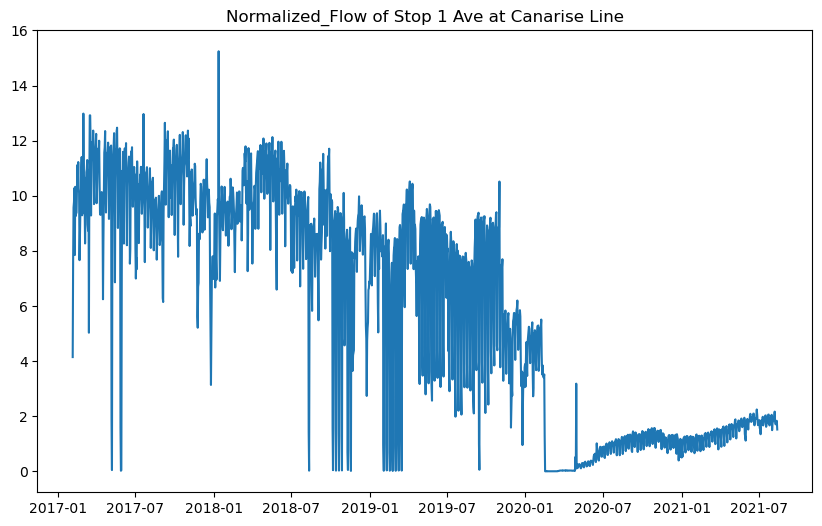

In [5]:
# Aggregating data cross a day

d1_time_flow_daily = df1_time_flow['Normalized_Flow'].resample('D').sum()

# plot the daily data cross the 2017~2022 period

plt.figure(figsize=(10, 6))

plt.plot(d1_time_flow_daily, linestyle='-')
plt.title('Normalized_Flow of Stop 1 Ave at Canarise Line')  
# Show the plot
plt.show()

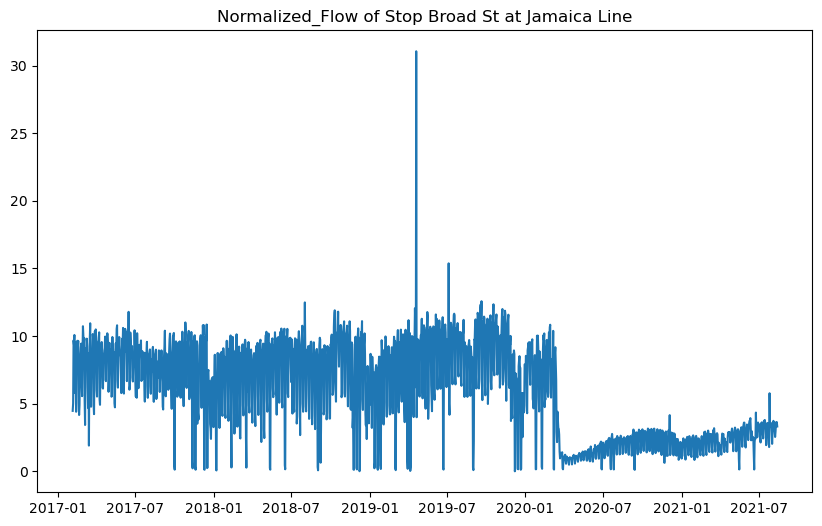

In [16]:
# The above figure shows a clear disruption caused by Covid.  
# we now look into another station, Station 2, Broad St at Jamaica Line


df[df['Line']=='Jamaica']['Stop Name'].unique()
df2 = df[(df['Stop Name'] == 'Broad St') & (df['Line'] == 'Jamaica')]

df2_time_flow = df2[['Datetime', 'Normalized_Flow']].copy()
df2_time_flow.set_index('Datetime', inplace=True)

# Aggregating data cross a day

d2_time_flow_daily = df2_time_flow['Normalized_Flow'].resample('D').sum()

# plot the daily data cross the whole window

plt.figure(figsize=(10, 6))

plt.plot(d2_time_flow_daily, linestyle='-')
plt.title('Normalized_Flow of Stop Broad St at Jamaica Line')  
# Show the plot
plt.show()

# The figure below also shows the significant distribution caused by Covid

In [7]:
# Given the covid disrution, we intend to break the ridership data before and after covid
# We do this respectively for df1 and df2, so that we will have 4 time series data.

In [8]:

# d1 pre-covid 
d1_pre_ridership = d1_time_flow_daily.iloc[0:1060]

# d1 post-covid
d1_post_ridership = d1_time_flow_daily.iloc[1200:]

# d2 pre-covid 
d2_pre_ridership = d2_time_flow_daily.iloc[0:1060]

# d1 post-covid
d2_post_ridership = d2_time_flow_daily.iloc[1200:]

In [9]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


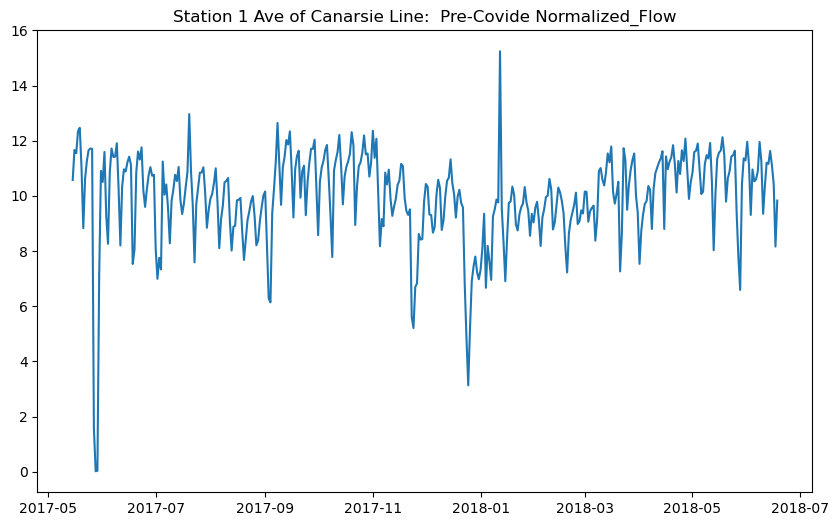

the lenth of the time-series data is 400


<Figure size 1600x1200 with 0 Axes>

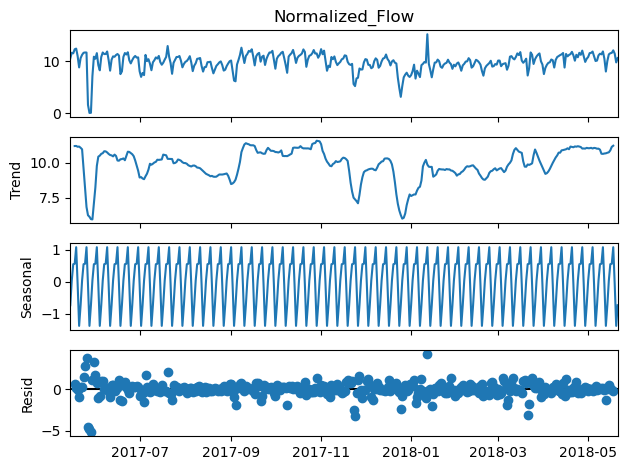

In [10]:
### Time analysis of Pre-Covid data of Station 1 -- Part 1

# d1 pre-covid
d1_pre_ridership = d1_time_flow_daily.iloc[100:100+400]


plt.figure(figsize=(10, 6))

plt.plot(d1_pre_ridership, linestyle='-')
plt.title('Station 1 Ave of Canarsie Line:  Pre-Covide Normalized_Flow')  
# Show the plot
plt.show()
d1_pre_ridership.head()



#pip install pmdarima

from pmdarima import auto_arima
import pandas as pd
import matplotlib.pyplot as plt  # Import matplotlib for plotting


y = d1_pre_ridership
print('the lenth of the time-series data is', len(y))


pd_steps = 28  # predicting 28 days ahead

y_train = y[:len(y) - pd_steps]
y_test = y[len(y) - pd_steps:]

# Decompose y_train to see the trend and seasonality
ts_decomp = sm.tsa.seasonal_decompose(y_train, model = 'additive')
plt.figure(figsize=(16, 12))
ts_decomp.plot()
plt.show()

In [11]:
# The above figure shows a strong seasonablity cross days exist in the ridership data.
# No obvious trend exists

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  372
Model:             SARIMAX(1, 0, 3)x(1, 0, [1], 7)   Log Likelihood                -539.640
Date:                             Sun, 17 Dec 2023   AIC                           1095.280
Time:                                     20:56:13   BIC                           1126.631
Sample:                                 05-15-2017   HQIC                          1107.730
                                      - 05-21-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0090      0.008      1.091      0.275      -0.007       0.025
ar.L1          0.7409      

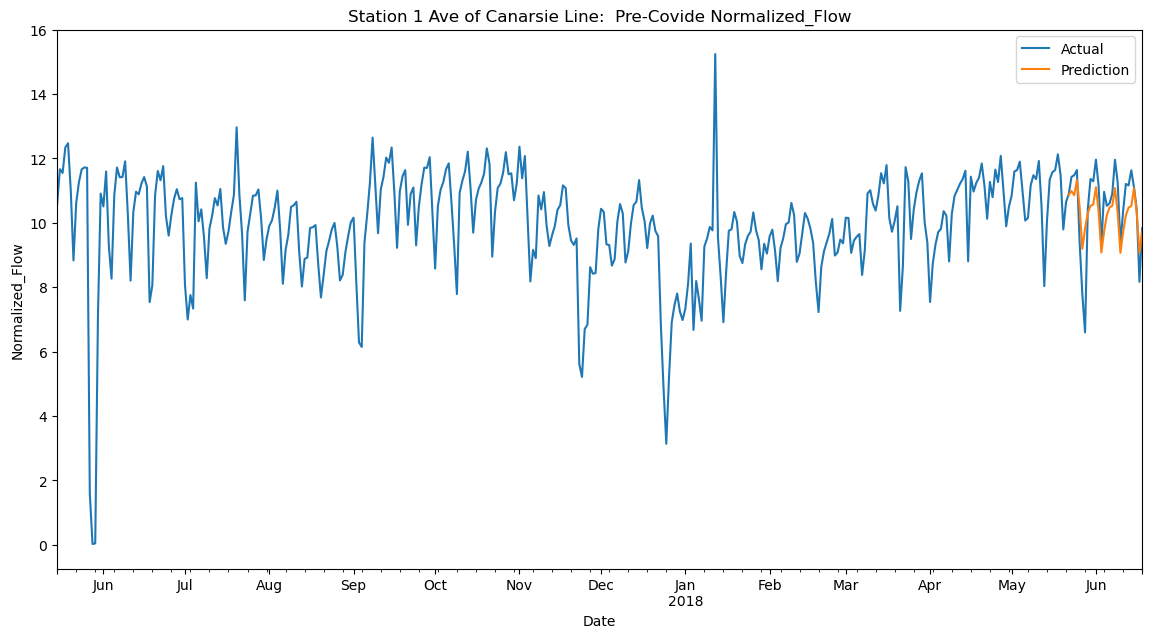

In [12]:
### Time analysis of Pre-Covid data of Station 1  -- Part 2

# Use auto_arima to find the best ARIMA parameters with seasonalty set to 7 from the above decomposition

model = auto_arima(y_train, seasonal=True, m=7)  

# Print the summary of the best model
print(model.summary())

# Forecast
forecast, conf_int = model.predict(n_periods=pd_steps, return_conf_int=True)
predictions = pd.Series(forecast, index=y_test.index)

fig, ax = plt.subplots(figsize=(14, 7))
y.plot(label='Actual', ax=ax)
predictions.plot(ax=ax, label='Prediction')
plt.xlabel('Date')
plt.ylabel('Normalized_Flow')
plt.legend()
plt.title('Station 1 Ave of Canarsie Line:  Pre-Covide Normalized_Flow')  
plt.show()

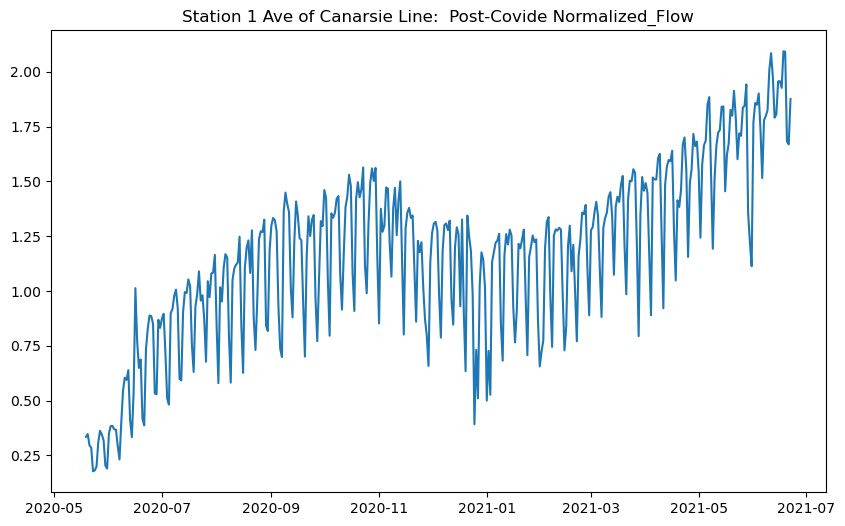

the lenth of the time-series data is 400


<Figure size 1600x1200 with 0 Axes>

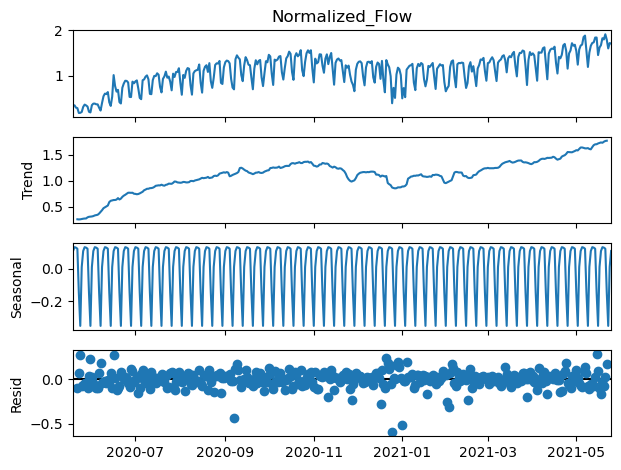

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  372
Model:             SARIMAX(1, 1, 1)x(2, 0, 1, 7)   Log Likelihood                 280.264
Date:                           Sun, 17 Dec 2023   AIC                           -548.527
Time:                                   20:58:34   BIC                           -525.030
Sample:                               05-19-2020   HQIC                          -539.195
                                    - 05-25-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3695      0.060      6.183      0.000       0.252       0.487
ma.L1         -0.8945      0.038    -23.751

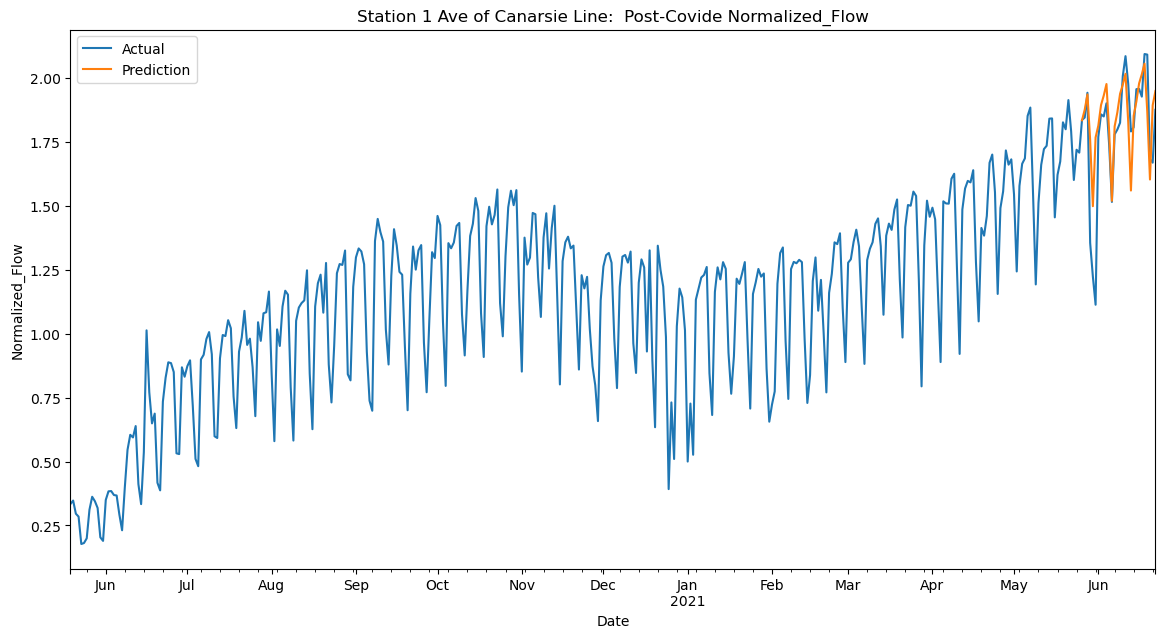

In [13]:
# SARIMA for d1_post_ridership (post Covid)

# d1 post-covid
d1_post_ridership = d1_time_flow_daily.iloc[1200:1200+400]


plt.figure(figsize=(10, 6))

plt.plot(d1_post_ridership, linestyle='-')
plt.title('Station 1 Ave of Canarsie Line:  Post-Covide Normalized_Flow')  
# Show the plot
plt.show()
d1_post_ridership.head()



#pip install pmdarima

from pmdarima import auto_arima
import pandas as pd
import matplotlib.pyplot as plt  # Import matplotlib for plotting


y = d1_post_ridership
print('the lenth of the time-series data is', len(y))


pd_steps = 28  # predicting 28 days ahead

y_train = y[:len(y) - pd_steps]
y_test = y[len(y) - pd_steps:]

# Decompose y_train
ts_decomp = sm.tsa.seasonal_decompose(y_train, model = 'additive')
plt.figure(figsize=(16, 12))
ts_decomp.plot()
plt.show()


# Use auto_arima to find the best ARIMA parameters with seasonalty set to 7 from the above decomposition

model = auto_arima(y_train, seasonal=True, m=7)  # Adjust 'm' based on your seasonality

# Print the summary of the best model
print(model.summary())

# Forecast
forecast, conf_int = model.predict(n_periods=pd_steps, return_conf_int=True)
predictions = pd.Series(forecast, index=y_test.index)

fig, ax = plt.subplots(figsize=(14, 7))
y.plot(label='Actual', ax=ax)
predictions.plot(ax=ax, label='Prediction')
plt.xlabel('Date')
plt.ylabel('Normalized_Flow')
plt.title('Station 1 Ave of Canarsie Line:  Post-Covide Normalized_Flow')  
plt.legend()
plt.show()

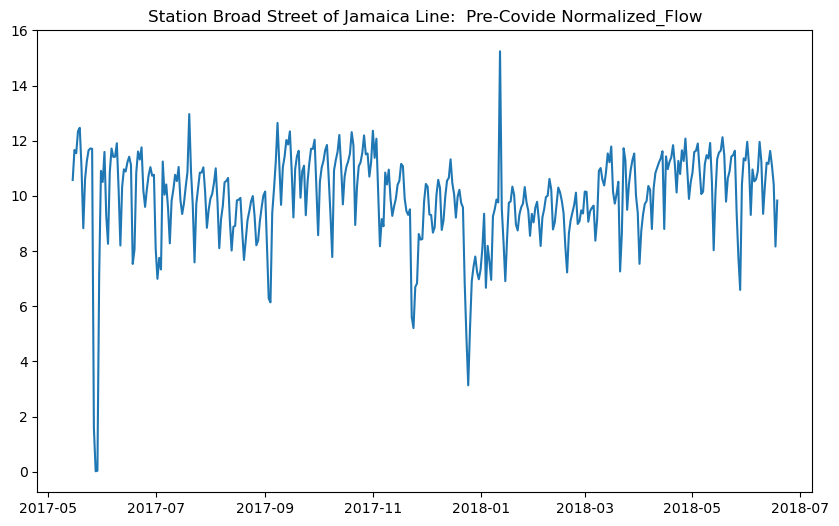

the length of the time-series data is 400


<Figure size 1600x1200 with 0 Axes>

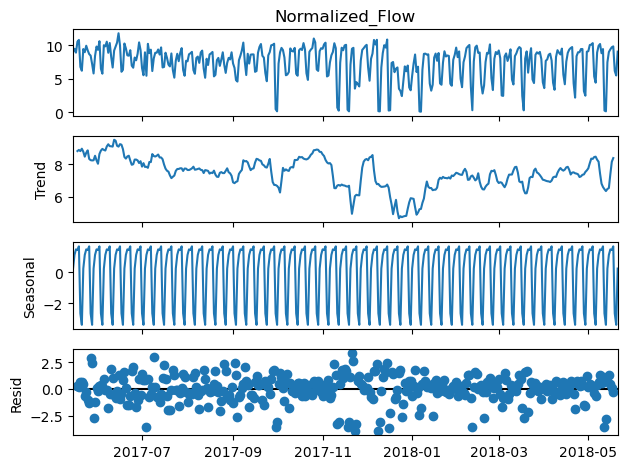

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  372
Model:             SARIMAX(5, 1, 1)x(2, 0, 1, 7)   Log Likelihood                -623.050
Date:                           Sun, 17 Dec 2023   AIC                           1268.100
Time:                                   21:00:53   BIC                           1311.178
Sample:                               05-15-2017   HQIC                          1285.209
                                    - 05-21-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.427e-05      0.000     -0.133      0.894      -0.000       0.000
ar.L1          0.5055      0.049     10.258

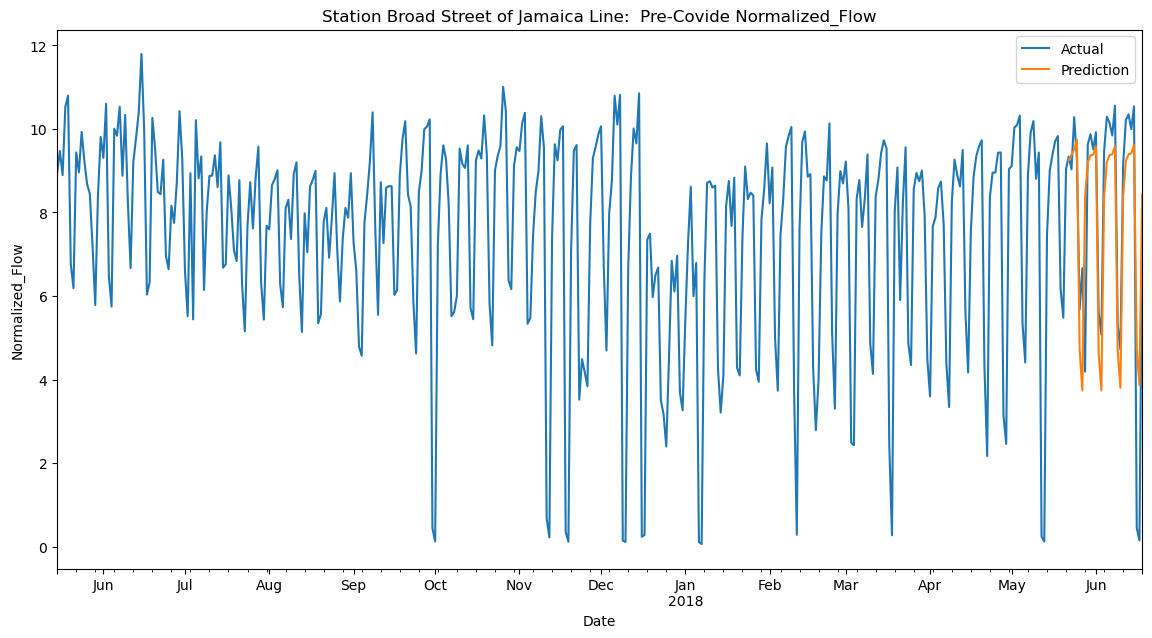

In [14]:
# SARIMA for d2_pre_ridership (pre-Covid)

# d2 pre-covid
d2_pre_ridership = d2_time_flow_daily.iloc[100:100+400]


plt.figure(figsize=(10, 6))

plt.plot(d1_pre_ridership, linestyle='-')
plt.title('Station Broad Street of Jamaica Line:  Pre-Covide Normalized_Flow')  
# Show the plot
plt.show()
d2_pre_ridership.head()



#pip install pmdarima

from pmdarima import auto_arima
import pandas as pd
import matplotlib.pyplot as plt  # Import matplotlib for plotting


y = d2_pre_ridership
print('the length of the time-series data is', len(y))


pd_steps = 28  # predicting 28 days ahead

y_train = y[:len(y) - pd_steps]
y_test = y[len(y) - pd_steps:]

# Decompose y_train
ts_decomp = sm.tsa.seasonal_decompose(y_train, model = 'additive')
plt.figure(figsize=(16, 12))
ts_decomp.plot()
plt.show()


# Use auto_arima to find the best ARIMA parameters with seasonalty set to 7 from the above decomposition

model = auto_arima(y_train, seasonal=True, m=7)  # Adjust 'm' based on your seasonality

# Print the summary of the best model
print(model.summary())

# Forecast
forecast, conf_int = model.predict(n_periods=pd_steps, return_conf_int=True)
predictions = pd.Series(forecast, index=y_test.index)

fig, ax = plt.subplots(figsize=(14, 7))
y.plot(label='Actual', ax=ax)
predictions.plot(ax=ax, label='Prediction')
plt.xlabel('Date')
plt.ylabel('Normalized_Flow')
plt.title('Station Broad Street of Jamaica Line:  Pre-Covide Normalized_Flow')  
plt.legend()
plt.show()

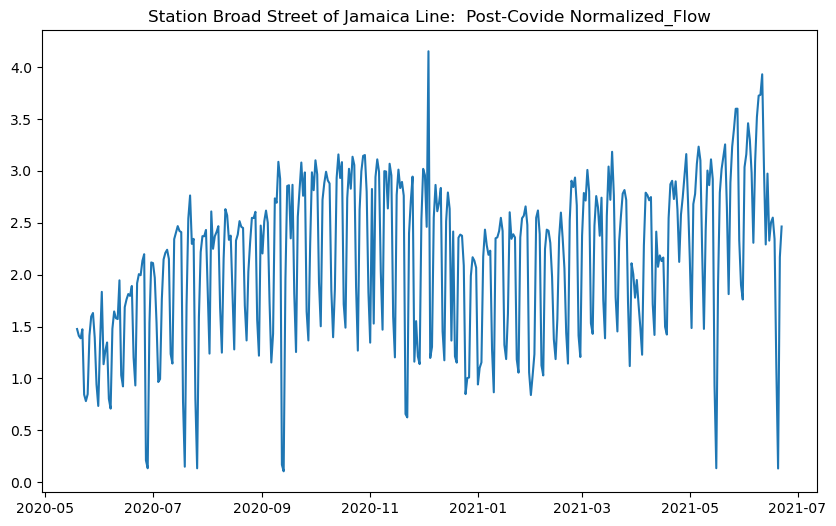

the lenth of the time-series data is 400


<Figure size 1600x1200 with 0 Axes>

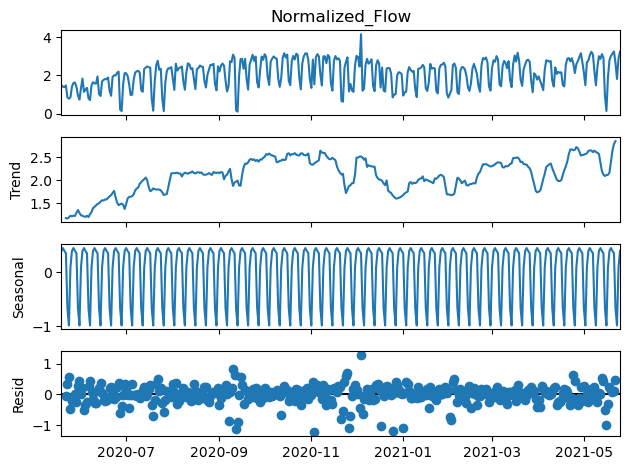

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  372
Model:             SARIMAX(3, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood                -155.091
Date:                                Sun, 17 Dec 2023   AIC                            330.181
Time:                                        21:03:56   BIC                            369.343
Sample:                                    05-19-2020   HQIC                           345.735
                                         - 05-25-2021                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.819e-05      0.000      0.177      0.860      -0.000       0.000
ar.

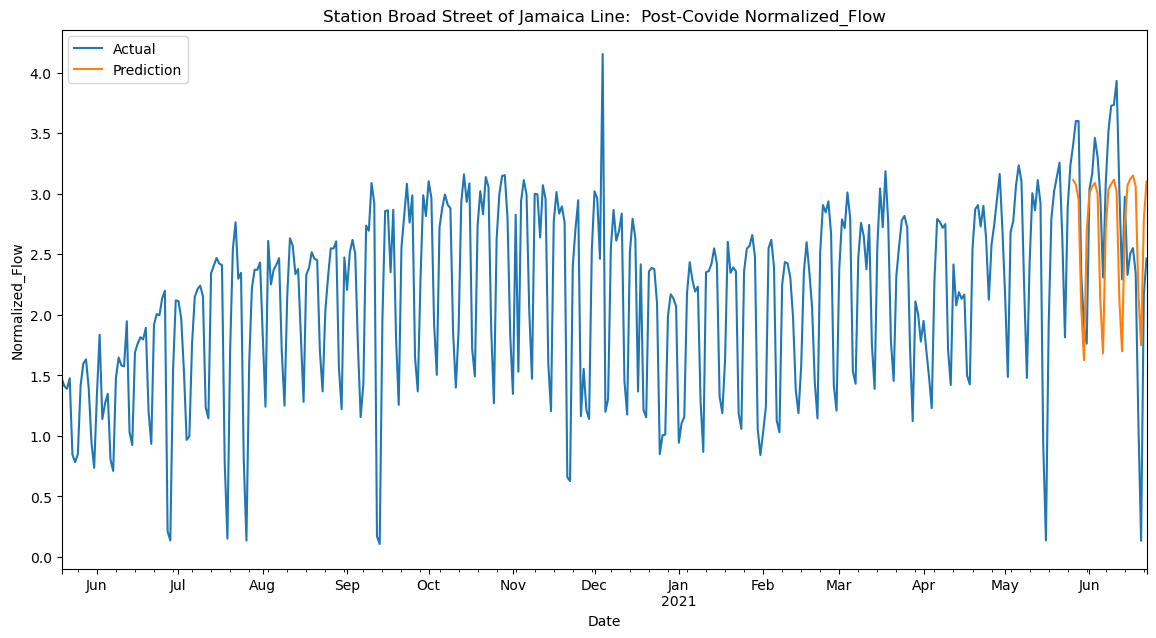

In [15]:
# SARIMA (Seasonal ARIMA) for d2_post_ridership   (Post-Covid)

# d2 post-covid
d2_post_ridership = d2_time_flow_daily.iloc[1200:1200+400]


plt.figure(figsize=(10, 6))

plt.plot(d2_post_ridership, linestyle='-')
plt.title('Station Broad Street of Jamaica Line:  Post-Covide Normalized_Flow')  
# Show the plot
plt.show()
d2_post_ridership.head()



#pip install pmdarima

from pmdarima import auto_arima
import pandas as pd
import matplotlib.pyplot as plt  # Import matplotlib for plotting


y = d2_post_ridership
print('the lenth of the time-series data is', len(y))


pd_steps = 28  # predicting 28 days ahead

y_train = y[:len(y) - pd_steps]
y_test = y[len(y) - pd_steps:]

# Decompose y_train
ts_decomp = sm.tsa.seasonal_decompose(y_train, model = 'additive')
plt.figure(figsize=(16, 12))
ts_decomp.plot()
plt.show()


# Use auto_arima to find the best ARIMA parameters with seasonalty set to 7 from the above decomposition

model = auto_arima(y_train, seasonal=True, m=7)  # Adjust 'm' based on your seasonality

# Print the summary of the best model
print(model.summary())

# Forecast
forecast, conf_int = model.predict(n_periods=pd_steps, return_conf_int=True)
predictions = pd.Series(forecast, index=y_test.index)

fig, ax = plt.subplots(figsize=(14, 7))
y.plot(label='Actual', ax=ax)
predictions.plot(ax=ax, label='Prediction')
plt.xlabel('Date')
plt.ylabel('Normalized_Flow')
plt.title('Station Broad Street of Jamaica Line:  Post-Covide Normalized_Flow')  
plt.legend()
plt.show()


#Model diagnostivs for d1-post

#model.plot_diagnostics(figsize=(16, 8))
#plt.show()  

And so we applied seasonal ARIMA models to the four time series we have, First Avenue before and after Covid, and Broad Street before and after COVID. In both cases, we used the final 28 days as testing data and 1 year data before that as training data. And the four fitted ARIMA models produced different results, whether it be the number of autoregressive terms, moving average terms, or integrated terms. This shows that ARIMA models vary for individual stations before and after COVID, and also differ among different stations in the same time period.

Even though the ARIMA models with seaonality predict the ridership data into the next 28 days with good accuracy, there are still ways to improve the prediction.  For example, if we could include information such as if a day is a holiday, and the daily weather related information, we shall expect better results. 